In [1]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
import pandas as pd

In [2]:
fname = 'data/covid_data_train.csv'
df = pd.read_csv(fname)
df = df.drop(['Unnamed: 0'], axis=1)
df.head()


,lat,lng,name,population,district,subject,density,ivl_per_100k,ivl_number,ekmo_per_100k,...,epirank_avia,epirank_bus,epirank_train,epirank_avia_cat,epirank_bus_cat,epirank_train_cat,whole_population,urban,rural,has_metro
0,52.651055,90.101159,Абаза,17111.0,Сибирский,Хакасия,8.68,NaN,NaN,NaN,...,NaN,2.278095e-11,NaN,NaN,0.0,NaN,64241.0,44921.0,19320.0,0.0
1,53.720902,91.442435,Абакан,165183.0,Сибирский,Хакасия,8.68,NaN,NaN,NaN,...,0.000903,8.343086e-10,0.001383,0.0,1.0,0.0,64241.0,44921.0,19320.0,0.0
2,53.682800,53.655701,Абдулино,20663.0,Приволжский,Оренбургская область,15.95,27.7,542.0,0.05,...,NaN,5.164813e-14,0.000376,NaN,0.0,0.0,270081.0,156761.0,113320.0,0.0
3,44.864953,38.157819,Абинск,34926.0,Южный,Краснодарский край,73.73,17.6,1000.0,0.07,...,NaN,1.187676e-14,0.000186,NaN,0.0,0.0,847286.0,452437.0,394849.0,0.0
4,56.525460,52.997251,Агрыз,19299.0,Приволжский,Татарстан,57.27,28.2,1100.0,0.00,...,NaN,4.750316e-13,0.001003,NaN,0.0,0.0,527462.0,371965.0,155497.0,0.0


In [3]:
unique_coords = ['lat', 'lng']
df = df.drop_duplicates(subset=unique_coords)
len(df)

417

In [4]:
towns = df[['name', 'population', 'district', 'region_x']]
towns.head()

,name,population,district,region_x
0,Абаза,17111.0,Сибирский,Республика Хакасия
1,Абакан,165183.0,Сибирский,Республика Хакасия
2,Абдулино,20663.0,Приволжский,Оренбургская область
3,Абинск,34926.0,Южный,Краснодарский край
4,Агрыз,19299.0,Приволжский,Республика Татарстан


In [5]:
#df[df['population'] >= 30000].index.to_list()

In [6]:
town_dict = towns.to_dict('index')
#list(town_dict.items())

In [7]:
import networkx as nx

def add_big_cities_edges(G, df, population=100000):
    big_cities = df[df['population'] >= population].index.to_list()
    for c1 in big_cities:
        for c2 in big_cities:
            if c1 != c2:
                G.add_edge(c1, c2, weight=10)
            else:
                G.add_edge(c1, c2, weight=15)
    return G

def add_subject_edges(G, df):
    subjects = df.region_x.unique().tolist()    
    for subject in subjects:
        subject_cities = df[df['region_x'] == subject].index.to_list()    
        for s1 in subject_cities:
            for s2 in subject_cities:
                if s1 != s2:
                    G.add_edge(s1, s2, weight=5)
                else:
                    G.add_edge(s1, s2, weight=15)
    return G

def add_district_edges(G):
    districts = df.district.unique().tolist()
    for district in districts:
        district_cities = df[df['district'] == district].index.to_list()
        for d1 in district_cities:
            for d2 in district_cities:            
                if d1 == d2: continue
                if not G.has_edge(d1, d2):
                    G.add_edge(d1, d2, weight=2)
    return G

def gen_graph(df):    
    G = nx.Graph()
    G.add_nodes_from(list(df.to_dict('index').items()))
    G = add_big_cities_edges(G, df)    
    G = add_subject_edges(G, df)    
    G = add_district_edges(G)
    
    return G
    

In [8]:
t_test = towns.iloc[0:100]
t_test.head()

,name,population,district,region_x
0,Абаза,17111.0,Сибирский,Республика Хакасия
1,Абакан,165183.0,Сибирский,Республика Хакасия
2,Абдулино,20663.0,Приволжский,Оренбургская область
3,Абинск,34926.0,Южный,Краснодарский край
4,Агрыз,19299.0,Приволжский,Республика Татарстан


In [9]:
G = gen_graph(towns)
len(G.edges)

15271

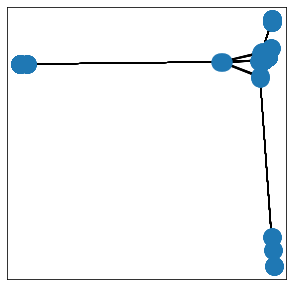

In [10]:
import matplotlib.pyplot as plt

fig = plt.figure(1, figsize=(5, 5))
layout = nx.spectral_layout(G)

nx.draw_networkx(G, with_labels=False, pos=layout)

plt.show()

In [12]:
import numpy as np
import networkx as nx
from sklearn.cluster import SpectralClustering
from sklearn import metrics
np.random.seed(1)

G = gen_graph(towns)

adj_mat = nx.to_numpy_matrix(G)

sc = SpectralClustering(2, affinity='precomputed', n_init=100)
sc.fit(adj_mat)

print('spectral clustering')
print(sc.labels_)
print('just for better-visualization: invert clusters (permutation)')
print(np.abs(sc.labels_ - 1))


spectral clustering
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 1 0 1 0 0 0 0
 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0
 0 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 1 0 0]
just for better-visualization: invert clusters (permutation)
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1